In [1]:
import numpy as np
from math import sqrt
from keras import initializers
import matplotlib.pyplot as plt 
from numpy.random import randn, randint
from keras.models import Model, load_model
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from numpy import zeros, ones, expand_dims, asarray
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.layers import LeakyReLU, Dropout, Embedding, BatchNormalization, Activation
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Concatenate

In [3]:
from keras.datasets import fashion_mnist
(x_train, train_label), (x_test, test_label) = fashion_mnist.load_data()
x_train1 = x_train.astype(np.float32) / 255
print(x_train1.shape)

(60000, 28, 28)


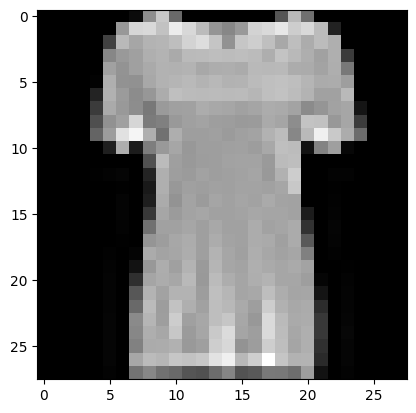

In [4]:
plt.imshow(x_train[10],'gray')

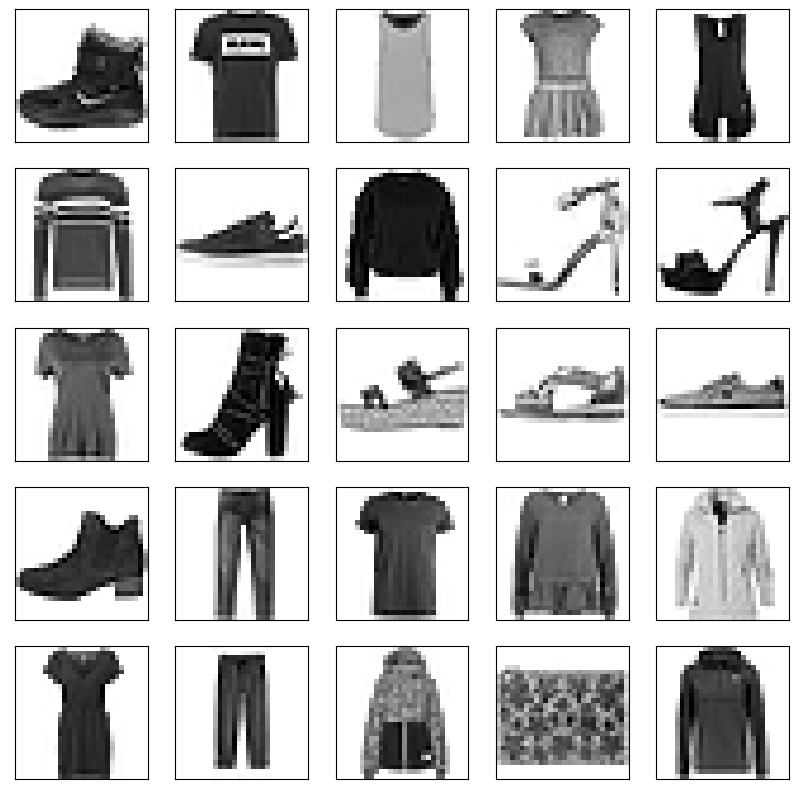

In [6]:
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train1[i], cmap = plt.cm.binary)
plt.show()

In [10]:
from numpy.random import randn, randint

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim) 
    return z_input

z_input=generate_latent_points(100,64)
z_input.shape

(64, 100)

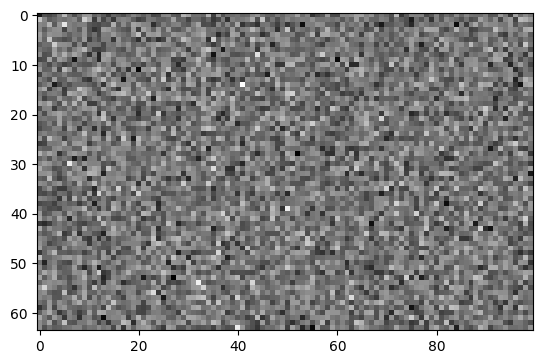

In [11]:
plt.imshow(z_input,'gray')

In [12]:
def generate_real_samples(x_train, n_samples):
    ix = randint(0, x_train.shape[0], n_samples) 
    X = x_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

Real_Data,y_real=generate_real_samples(x_train1,64)
Real_Data.shape
y_real.shape

(64, 1)

In [14]:
print(y_real[:5])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [15]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [16]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('sigmoid')(gen)
    out_layer = Reshape((28, 28, 1))(out_layer)
    model = Model(in_lat, out_layer)
    return model

In [17]:
generator = define_generator(100)

images, y=generate_fake_samples(generator,100,64)

images.shape

c:\users\maalaoui\appdata\local\programs\python\python38\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2/2 [==============================] - 0s 20ms/step


(64, 28, 28, 1)

In [18]:
images1=images.reshape(64,28,28)
images1.shape

(64, 28, 28)

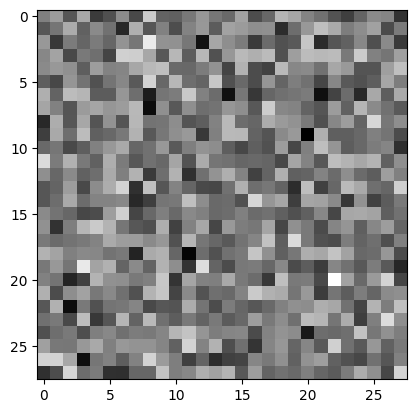

In [19]:
plt.imshow(images1[63],'gray')

In [20]:
def define_discriminator(in_shape=(28, 28, 1)):
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = define_discriminator()

In [21]:
def define_gan(g_model, d_model):
    d_model.trainable = False 
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

gan_model = define_gan(generator, discriminator)

In [26]:
for i in range(200):
   X_real, y_real = generate_real_samples(x_train1, 60000)
   d_loss_r, d_acc_r = discriminator.train_on_batch(X_real, y_real)
   X_fake, y_fake = generate_fake_samples(generator, 100, 60000)
   d_loss_f, d_acc_f = discriminator.train_on_batch(X_fake, y_fake)
   z_input = generate_latent_points(100, 60000) 
   y_gan = ones((60000, 1)) 
   g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
   print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' 
         % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))

1875/1875 [==============================] - 9s 5ms/step
>1, dr[0.037,0.991], df[0.666,0.652], g[1.290,0.006]
1875/1875 [==============================] - 10s 5ms/step
>2, dr[0.048,0.990], df[0.364,0.994], g[1.707,0.000]
1875/1875 [==============================] - 9s 5ms/step
>3, dr[0.172,0.891], df[0.432,0.968], g[1.485,0.000]
1875/1875 [==============================] - 9s 5ms/step
>4, dr[0.094,0.963], df[0.471,0.926], g[1.672,0.000]
1875/1875 [==============================] - 9s 5ms/step
>5, dr[0.174,0.895], df[0.424,0.974], g[1.709,0.000]
1875/1875 [==============================] - 9s 5ms/step
>6, dr[0.095,0.958], df[0.353,0.997], g[1.912,0.000]
1875/1875 [==============================] - 10s 5ms/step
>7, dr[0.170,0.901], df[0.446,0.971], g[1.513,0.000]
1875/1875 [==============================] - 10s 5ms/step
>8, dr[0.065,0.976], df[0.360,0.991], g[1.771,0.000]
1875/1875 [==============================] - 10s 5ms/step
>9, dr[0.156,0.910], df[0.381,0.992], g[1.564,0.000]
1875/1

In [27]:
images2,y = generate_fake_samples(generator,100,20)

1/1 [==============================] - 0s 267ms/step


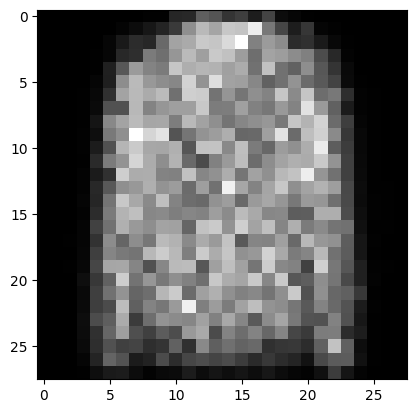

In [28]:
images2.shape
images2=images2.reshape(20,28,28)

plt.imshow(images2[4],'gray')